Iter 0: Loss = 564157984.27590358
Iter 0: Gradient = 94.32382696
Iter 10: Loss = 77873632.03222300
Iter 10: Gradient = 32.01134164
Iter 20: Loss = 15090286.62018794
Iter 20: Gradient = 12.63243550
Iter 30: Loss = 3966356.13805710
Iter 30: Gradient = 6.09410161
Iter 40: Loss = 1287620.89924568
Iter 40: Gradient = 3.62389252
Iter 50: Loss = 506746.34711520
Iter 50: Gradient = 2.62516264
Iter 60: Loss = 253420.96673401
Iter 60: Gradient = 2.21033724
Iter 70: Loss = 163958.70107876
Iter 70: Gradient = 2.02512333
Iter 80: Loss = 128952.11488783
Iter 80: Gradient = 1.91528055
Iter 90: Loss = 113251.81618842
Iter 90: Gradient = 1.85763611


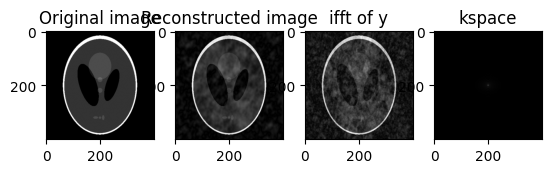

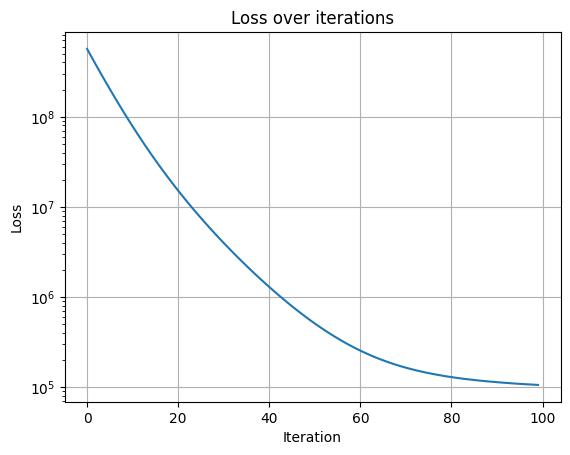

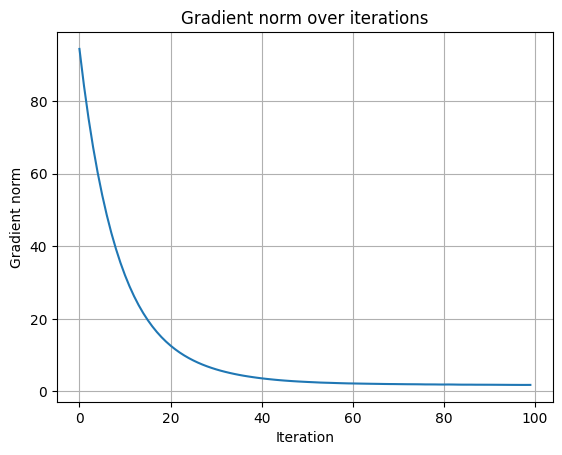

'\nplt.figure()\nplt.imshow(np.log(1 + np.abs(masked_kspace_shepp_shifted)), cmap=\'gray\') # np.log to compress the dynamic range\nplt.colorbar()\nplt.title("Magnitude of Complex Image")\n\nplt.figure()\nplt.imshow(np.angle(masked_kspace_shepp_shifted), cmap=\'twilight\', vmin=-np.pi, vmax=np.pi)\nplt.colorbar()\nplt.title("Phase of Complex Image")\n\nplt.figure()\nplt.imshow(masked_reconstructed)\n\nplt.show()\n'

In [5]:
import sys
import os

# Add the parent directory of MAP to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


import torch
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from MAP.masks import (
    PseudoRandomColumnMask,
    SimpleMask,
    BernoulliMask,
    CenteredBernoulliMask,
    VariableDensityMask,
)
from MAP.map_tv_minimize import MAPEstimator


# load iamge
shepp_logan = ski.data.shepp_logan_phantom()

# create mask (in the F domain of course)
column_mask = SimpleMask(2).mask_columns(shepp_logan)
row_mask = SimpleMask(3).mask_rows(shepp_logan)
bernoulli_mask = BernoulliMask(0.88, seed=30).generate(shepp_logan.shape)
centered_bernoulli_mask = CenteredBernoulliMask(0.75, 0.25, seed=30).generate(
    shepp_logan.shape
)
vd_mask = VariableDensityMask("gaussian", 2, seed=30).generate(shepp_logan.shape)
pseudorand_mask = PseudoRandomColumnMask(shepp_logan.shape, acceleration=4, seed=30).get_mask()

# the 'actual' measurement
y = centered_bernoulli_mask * np.fft.fft2(shepp_logan)

# x_init options
# x_init = np.fft.ifft2(bernoulli_mask * np.fft.fft2(shepp_logan)).real
#x_init = np.zeros_like(np.fft.ifft2(y).real)

# init the MAP
map_estimator = MAPEstimator(centered_bernoulli_mask, 0.95, 0.01, 1e-2, 0.1, 100)

img_reconstruct = map_estimator.subgradient_descent(y)

samples = map_estimator.langevin_sampling(y, 150, 20, 3)
posterior_mean = np.mean(
    samples, axis=0
)  # Compute a point estimate (e.g., posterior mean)
posterior_std = np.std(
    samples, axis=0
)  # Estimate uncertainty (e.g., pixel-wise variance)

"""
kspace_shepp = np.fft.fft2(shepp_logan)
kspace_shepp_shifted = np.fft.fftshift(kspace_shepp) # shift to center the zero frequency for better visualization

reconstructed = np.real(np.fft.ifft2(kspace_shepp))
reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))

#masked_kspace_shepp = column_mask(kspace_shepp)
#masked_kspace_shepp_shifted = np.fft.fftshift(masked_kspace_shepp) # shift to center the zero frequency for better visualization

#masked_reconstructed = np.real(np.fft.ifft2(masked_kspace_shepp))
masked_reconstructed_mag = np.real(np.fft.ifft2(np.abs(kspace_shepp) * np.exp(1j * 0)))
masked_reconstructed_phase = np.real(np.fft.ifft2(np.exp(1j * np.angle(kspace_shepp))))
"""

# print(shepp_logan)
#print("------------------------")
# print("grad_y - min:", np.min(grad_y), "max:", np.max(grad_y))
# print("max value in x before fft2:", np.max(np.abs(shepp_logan)))

plt.subplot(1, 4, 1)
plt.title("Original image")
plt.imshow(shepp_logan, cmap="gray")
plt.subplot(1, 4, 2)
plt.title("Reconstructed image")
plt.imshow(np.abs(img_reconstruct), cmap="gray")
plt.subplot(1, 4, 3)
plt.title("ifft of y")
plt.imshow(np.abs(np.fft.ifft2(y)), cmap="gray")
plt.subplot(1, 4, 4)
plt.title("kspace")
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(shepp_logan))), cmap='gray')
plt.show()

# plt.imshow(img_reconstruct - np.abs(np.fft.ifft2(y)))
# plt.imshow(img_reconstruct - x_init)
# plt.title("Difference image")
# plt.colorbar()

# # langevin
# plt.imshow(posterior_mean, cmap="gray")
# plt.title("Posterior Mean Reconstruction")
# plt.colorbar()
# plt.show()

# loss
plt.plot(map_estimator.loss_history)
plt.title("Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.yscale('log')
plt.show()

# gradient
plt.plot(map_estimator.grad_norm_history)
plt.title("Gradient norm over iterations")
plt.xlabel("Iteration")
plt.ylabel("Gradient norm")
plt.grid(True)
#plt.yscale('log')
plt.show()


# plt.imshow(posterior_std, cmap='hot')
# plt.title('Uncertainty Map')
# plt.colorbar()
# plt.show()

"""
plt.figure()
plt.imshow(np.log(1 + np.abs(masked_kspace_shepp_shifted)), cmap='gray') # np.log to compress the dynamic range
plt.colorbar()
plt.title("Magnitude of Complex Image")

plt.figure()
plt.imshow(np.angle(masked_kspace_shepp_shifted), cmap='twilight', vmin=-np.pi, vmax=np.pi)
plt.colorbar()
plt.title("Phase of Complex Image")

plt.figure()
plt.imshow(masked_reconstructed)

plt.show()
"""
